# AI Training with AutoML approach

Results are based on current preprocessing, which is not finished yet.

In [133]:
#Imports:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import autokeras as ak

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE 
from tensorflow.keras.models import load_model



In [103]:
# Methods to test the predictions

def count_points(pred, gold):
    df = pd.merge(pred, gold, on=['userID', 'itemID'], suffixes=('_pred', '_gold'))
    df['points'] = df.apply(_compute_points_for_row, axis=1)
    return df['points'].sum()

def _compute_points_for_row(row):
    y_pred, y_gold = row.prediction_pred, row.prediction_gold
    if y_pred == y_gold:
        # one point if "no order" (0) is predicted correctly; three points if order week is predicted correctly
        return 1 if y_pred == 0 else 3
    # one point if order is predicted correctly (but not the correct week), otherwise zero points
    return 1 if (y_pred > 0 and y_gold > 0) else 0

### Load data with small preprocessing

In [144]:
#loading the datasets 

df_orders = pd.read_csv("orders__jan_labeled.csv", sep = ",") #labeled
df_items = pd.read_csv("items.csv", sep = "|") #items
df_category = pd.read_csv("category_hierarchy.csv", sep = "|") #categories

df_orders

,date,userID,itemID,order,label
0,2021-01-01,26522,22980,1,0
1,2021-01-01,26522,28715,2,0
2,2021-01-01,26522,2837,1,0
3,2021-01-01,12931,23242,1,0
4,2021-01-01,27421,4832,1,0
...,...,...,...,...,...
165652,2021-01-31,13072,7476,1,0
165653,2021-01-31,43776,30138,1,0
165654,2021-01-31,444,1932,1,0
165655,2021-01-31,20864,28739,2,0


In [145]:
print(len(df_items['itemID'].unique())) #checking for duplicates
print(len(df_items))

32776
32776


In [146]:
result = pd.merge(df_orders, df_items, on="itemID") #merging the dataset on itemID 

In [147]:
result = result.drop(['categories'], axis = 1) #dropping the categories
result = result.drop(['date'], axis = 1) # dropping the date

labels = result["label"] # generating a label dataset
data = result.drop(['label'], axis = 1) #dropping label
data = result.drop(['order'], axis = 1) #dropping label

data

,userID,itemID,label,brand,feature_1,feature_2,feature_3,feature_4,feature_5
0,26522,22980,0,523,6,0,249,3,45
1,26522,28715,0,1368,4,1,487,0,66
2,2794,28715,0,1368,4,1,487,0,66
3,4601,28715,0,1368,4,1,487,0,66
4,31444,28715,0,1368,4,1,487,0,66
...,...,...,...,...,...,...,...,...,...
165652,5417,23561,0,1111,4,0,161,0,66
165653,37541,31740,0,340,10,1,503,0,45
165654,17877,10342,0,614,4,1,468,0,104
165655,10136,6379,0,926,10,2,501,0,9


In [148]:
enc = OneHotEncoder(handle_unknown='ignore') #onehotencoder
cols = ["feature_1", "feature_2", "feature_4"] #columns to onehot encode
enc.fit(data[cols])
encoder_df = pd.DataFrame(enc.transform(data[cols]).toarray()) #encoding
data = data[["userID", "itemID", "brand", "feature_3", "feature_5"]].join(encoder_df) #merging


In [149]:
data

,userID,itemID,brand,feature_3,feature_5,0,1,2,3,4,...,11,12,13,14,15,16,17,18,19,20
0,26522,22980,523,249,45,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,26522,28715,1368,487,66,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2794,28715,1368,487,66,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4601,28715,1368,487,66,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,31444,28715,1368,487,66,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165652,5417,23561,1111,161,66,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
165653,37541,31740,340,503,45,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
165654,17877,10342,614,468,104,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
165655,10136,6379,926,501,9,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [150]:
#orders = np.array(orders)
#data = np.array(data)
print(labels)
#lenc = LabelEncoder()
#lenc = lenc.fit(labels)
#labels = lenc.transform(labels)
#labels = np.array(labels).reshape(-1,1)

0         0
1         0
2         0
3         0
4         0
         ..
165652    0
165653    0
165654    0
165655    0
165656    0
Name: label, Length: 165657, dtype: int64


array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

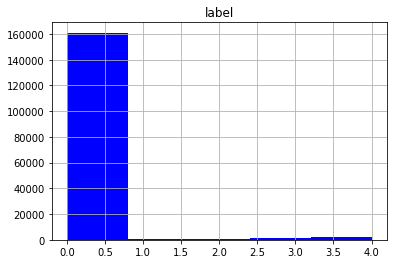

In [151]:
pd.DataFrame(labels).hist(bins=5,color='blue' ) #plot histogram

In [152]:
X_train, X_test, y_train, y_test = train_test_split( data, labels, test_size=0.1, random_state=42) #split data in test and train

combinedData = pd.DataFrame(X_train).copy() #combine train for samling
combinedData["label"] = pd.DataFrame(y_train)
combinedData

,userID,itemID,brand,feature_3,feature_5,0,1,2,3,4,...,12,13,14,15,16,17,18,19,20,label
81895,26842,31323,225,395,156,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
98688,11317,9215,286,82,144,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
72617,11045,9541,366,498,13,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
143423,5585,27386,402,536,91,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
125174,31621,21762,322,536,144,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,44892,19824,523,503,85,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
103694,40380,29506,791,506,9,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
131932,21026,13386,1180,487,16,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
146867,15476,31928,406,507,17,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [153]:
sm = SMOTE(random_state=42)
X_train, y_train=  sm.fit_resample(X_train, y_train)

X_train = np.array(X_train)
y_train = np.array(y_train)

C:\Users\knabp_000\anaconda3\envs\Envi\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [154]:
X_train, X_val, y_train, y_val= train_test_split( X_train, y_train, test_size=0.1, random_state=42)
print(len(X_train.shape), len(X_test.shape), len(X_val.shape))
X_train.shape

2 2 2


(652014, 26)

In [155]:
y_train

array([4, 0, 0, ..., 0, 4, 3], dtype=int64)

### AutoML Training

We use Autokeras to train the AI, which uses DL libraries.

In [156]:
model = ak.AutoModel(
    inputs=[ak.StructuredDataInput()],
    outputs=[ak.RegressionHead()],
    max_trials=5,
    overwrite = True
)


In [158]:
model.fit(
    x=X_train, y=y_train, epochs=100, batch_size=64, validation_data= [X_val, y_val]
)

Trial 5 Complete [00h 12m 03s]
val_loss: 1.3563296794891357

Best val_loss So Far: 1.331097960472107
Total elapsed time: 01h 14m 17s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
10188/10188 [==============================] - 22s 2ms/step - loss: 2.0020 - mean_squared_error: 2.0020 - val_loss: 1.4322 - val_mean_squared_error: 1.4322
Epoch 2/100
10188/10188 [==============================] - 21s 2ms/step - loss: 1.4833 - mean_squared_error: 1.4833 - val_loss: 1.4014 - val_mean_squared_error: 1.4014
Epoch 3/100
10188/10188 [==============================] - 21s 2ms/step - loss: 1.4551 - mean_squared_error: 1.4551 - val_loss: 1.3926 - val_mean_squared_error: 1.3926
Epoch 4/100
10188/10188 [==============================] - 21s 2ms/step - loss: 1.4438 - mean_squared_error: 1.4438 - val_loss: 1.3900 - val_mean_squared_error: 1.3900
Epoch 5/100
10188/10188 [==============================] - 21s 2ms/step - loss: 1.4375 - mean_squared_error: 1.4375 - val_loss: 1.3812 - val_mean_squared_err

In [138]:
model = load_model("model_autokeras_dec", custom_objects=ak.CUSTOM_OBJECTS)


In [159]:
model = model.export_model()


try:
    model.save("model_autokeras_jan", save_format="tf")
except Exception:
    model.save("model_autokeras_jan.h5")

INFO:tensorflow:Assets written to: model_autokeras_jan\assets


<AxesSubplot:>

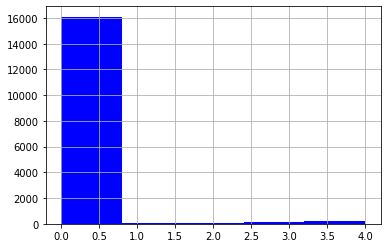

In [160]:
y_test.hist(bins=5,color='blue' ) #plot histogram

### Testing the model

In [161]:
to_test = X_val
truth = y_val

res = np.round(model.predict(to_test))
info = pd.DataFrame(to_test)
stand = pd.DataFrame()
stand["userID"] = info[[0]]
stand["itemID"] = info[[1]]
pred = stand.copy()
gold = stand.copy()
pred["prediction"] = np.round(res)#lenc.inverse_transform((res.astype(int))))
gold["prediction"] = np.round(truth)

In [162]:
points = count_points(pred, gold)
max_points = count_points(gold, gold)
score = points / max_points

In [163]:
print(points)
print(max_points)
print(score)

128534
242826
0.529325525273241


### Applying model on new Data

In [164]:
name = 'submission_jan'

df_submission = pd.read_csv( name+".csv", sep = "|")

result_pred = pd.merge(df_submission, df_items, on="itemID")

result_pred = result_pred.drop(['categories'], axis = 1)
data = result_pred.drop(['prediction'], axis = 1)
                        
cols = ["feature_1", "feature_2", "feature_4"]

encoder_df = pd.DataFrame(enc.transform(data[cols]).toarray())
data = data[["userID","itemID", "brand", "feature_3", "feature_5"]].join(encoder_df)

data

,userID,itemID,brand,feature_3,feature_5,0,1,2,3,4,...,11,12,13,14,15,16,17,18,19,20
0,0,20664,408,284,66,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,23363,20664,408,284,66,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,28231,193,468,108,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,13,2690,406,491,66,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,15,1299,1056,474,108,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9935,46049,17984,449,207,45,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9936,46069,29992,280,484,44,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9937,46117,8847,143,46,69,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9938,46124,19677,1006,491,154,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [165]:
res = np.round(model.predict(np.array(data)))
df = pd.DataFrame()
df["prediction"] = pd.DataFrame(np.int_(res))
df

,prediction
0,1
1,1
2,1
3,1
4,1
...,...
9935,1
9936,1
9937,1
9938,1


array([[<AxesSubplot:title={'center':'prediction'}>]], dtype=object)

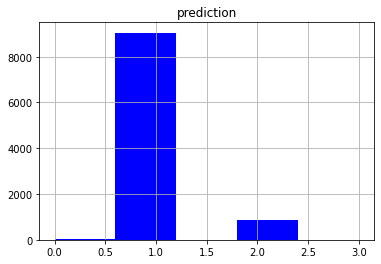

In [166]:
df.hist(bins=5,color='blue' )

In [167]:
df.sort_values(by = ["prediction"],ascending=False)

,prediction
7508,3
8489,3
7507,3
5290,3
5291,3
...,...
5710,0
5711,0
5712,0
5713,0


In [168]:
df_submission["prediction"] = df["prediction"]
df_submission

,userID,itemID,prediction
0,0,20664,1
1,0,28231,1
2,13,2690,1
3,15,1299,1
4,15,20968,1
...,...,...,...
9935,46118,20106,1
9936,46124,19677,1
9937,46125,12878,1
9938,46127,7963,1


In [169]:
df_submission.to_csv(name+"_pred.csv", sep='|')